In [8]:
import os, torch,shutil, numpy as np

In [9]:
from glob import glob

In [10]:
from PIL import Image

In [11]:
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import transforms as T


In [12]:
torch.manual_seed(2023)

In [13]:
class CustomData(Dataset):
    
    def __init__(self,root,transformations = None):
        self.transformations = transformations
        self.im_paths = sorted(glob(f'{root}/*/*'))
        
        # to count the number of clas lables and 
        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        
        for  idx,im_path in enumerate(self.im_paths):
            class_name =self.get_class(im_path)
            if class_name not in self.cls_names:
                self.cls_names[class_name] = count # initailize class
                self.cls_counts[class_name] = 1 # increaese the count of that class
                count += 1
            else: self.cls_counts[class_name] += 1
            
    def get_class(self, path): return os.path.dirname(path).split("/")[-1]

    def __len__(self): return len(self.im_paths)

    def __getitem__(self,idx):
        im_path=self.im_paths[idx]
        im = Image.open(im_path).convert('RGB')
        gt = self.cls_names[self.get_class(im_path)]
        
        if self.transformations is not None:
            im = self.transformations(im)
        
        return im, gt
            

def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):
    
    ds = CustomData(root = root, transformations = transformations)
    
    total_len = len(ds)
    tr_len = int(total_len * split[0]) # training set
    vl_len = int(total_len * split[1]) # validation set size
    ts_len = total_len - (tr_len + vl_len) # testing set size
    
    tr_ds, vl_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, vl_len, ts_len])
    
    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns), \
        DataLoader(vl_ds, batch_size = bs, shuffle = False, num_workers = ns), \
        DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns) \
    
    return tr_dl, val_dl, ts_dl, ds.cls_names

root = "Celebrity Images"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root = root, transformations = tfs, bs = 32)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)

8
1
15
{'maria_sharapova': 0, 'messi': 1, 'ronaldo': 2, 'shahrukh_khan': 3, 'virat_kohli': 4}


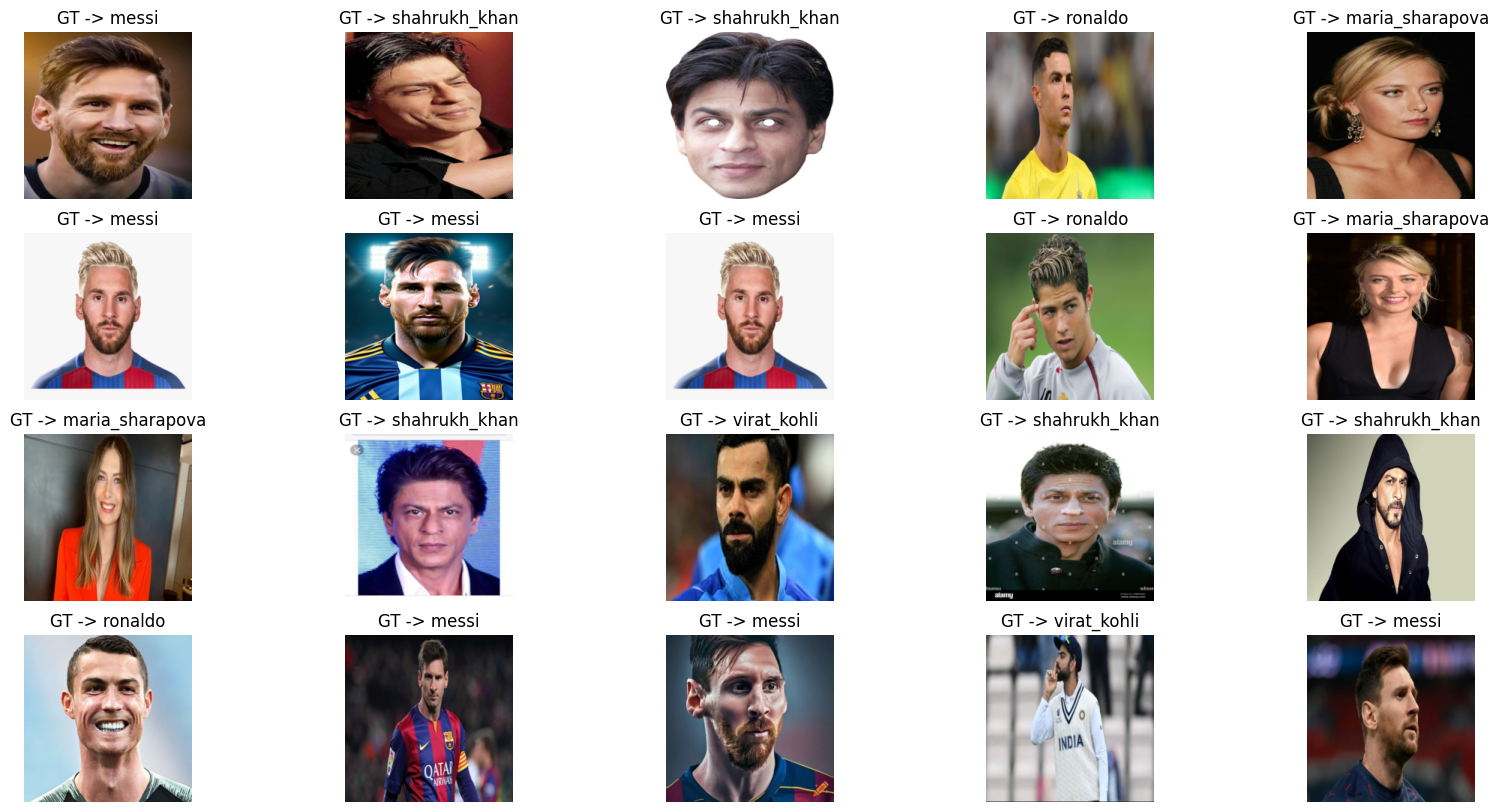

In [14]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):
    
    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]),
                          T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], # providing 3  means for 3 channels
                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]), # providing 3  std for 3 channels
                         T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs 
    
    return (invTrans(t) * 255).detach().squeeze().cpu().\
                permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):
    
    assert cmap in ["rgb", "gray"], "No encoding Retina available!" #else error
    if cmap == "rgb": cmap = "viridis"
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):
        
        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")
            
visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

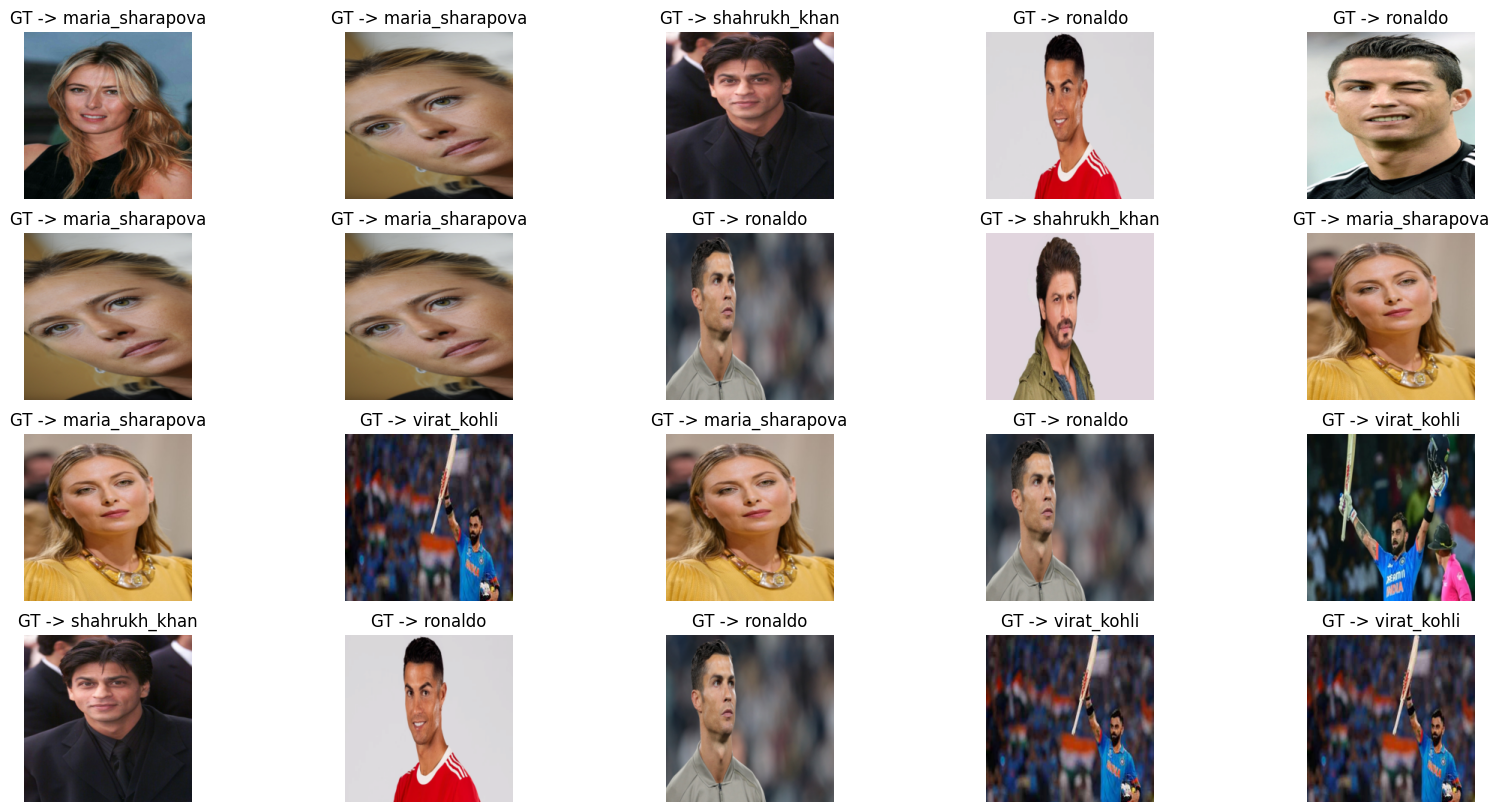

In [15]:
visualize(val_dl.dataset, 20, 4, "rgb", list(classes.keys()))

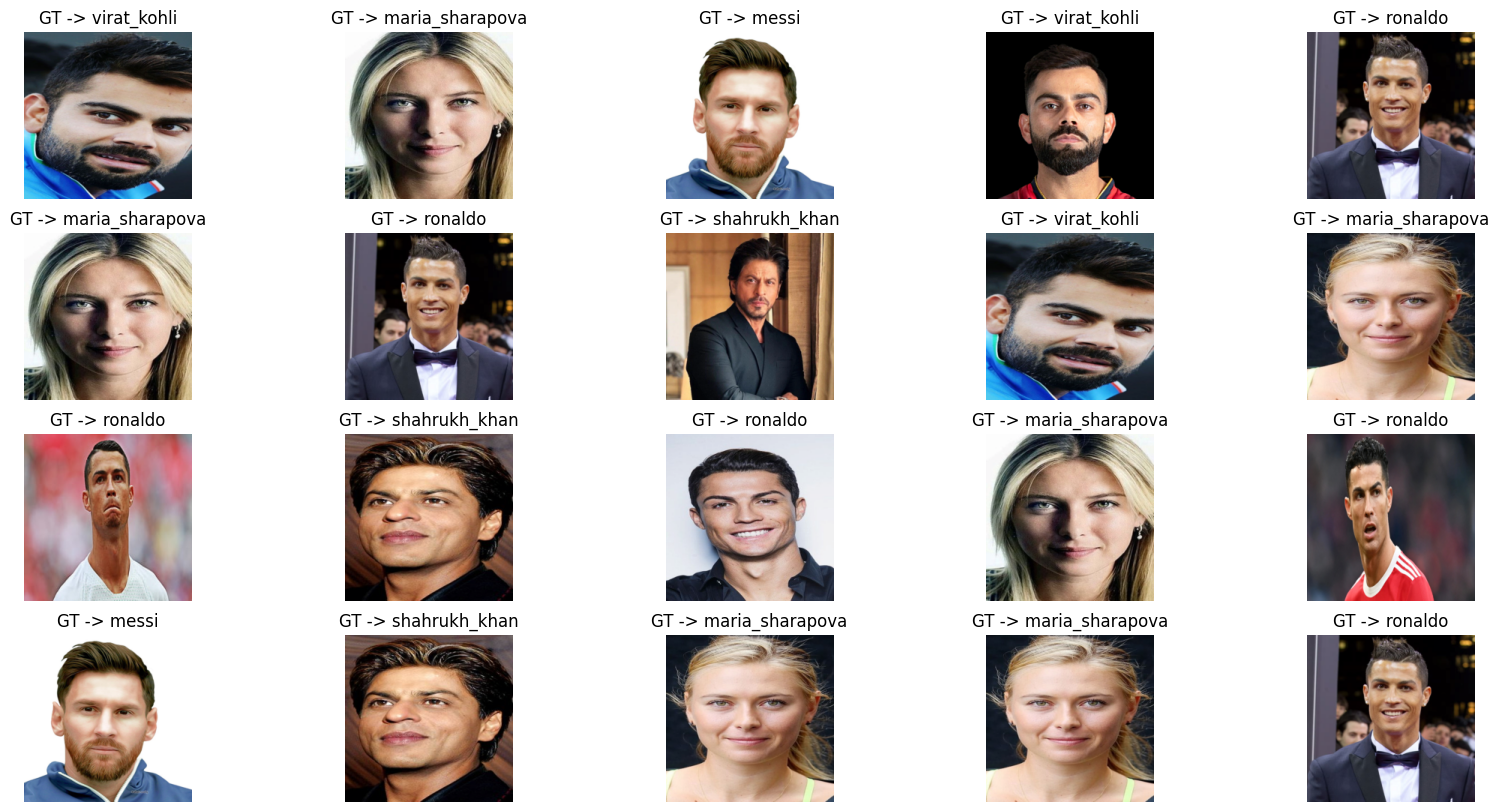

In [16]:
visualize(ts_dl.dataset, 20, 4, "rgb", list(classes.keys()))

## set and skew / imbalance data or not 

/tmp/ipykernel_42931/3474346843.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cls_names, rotation = 60)


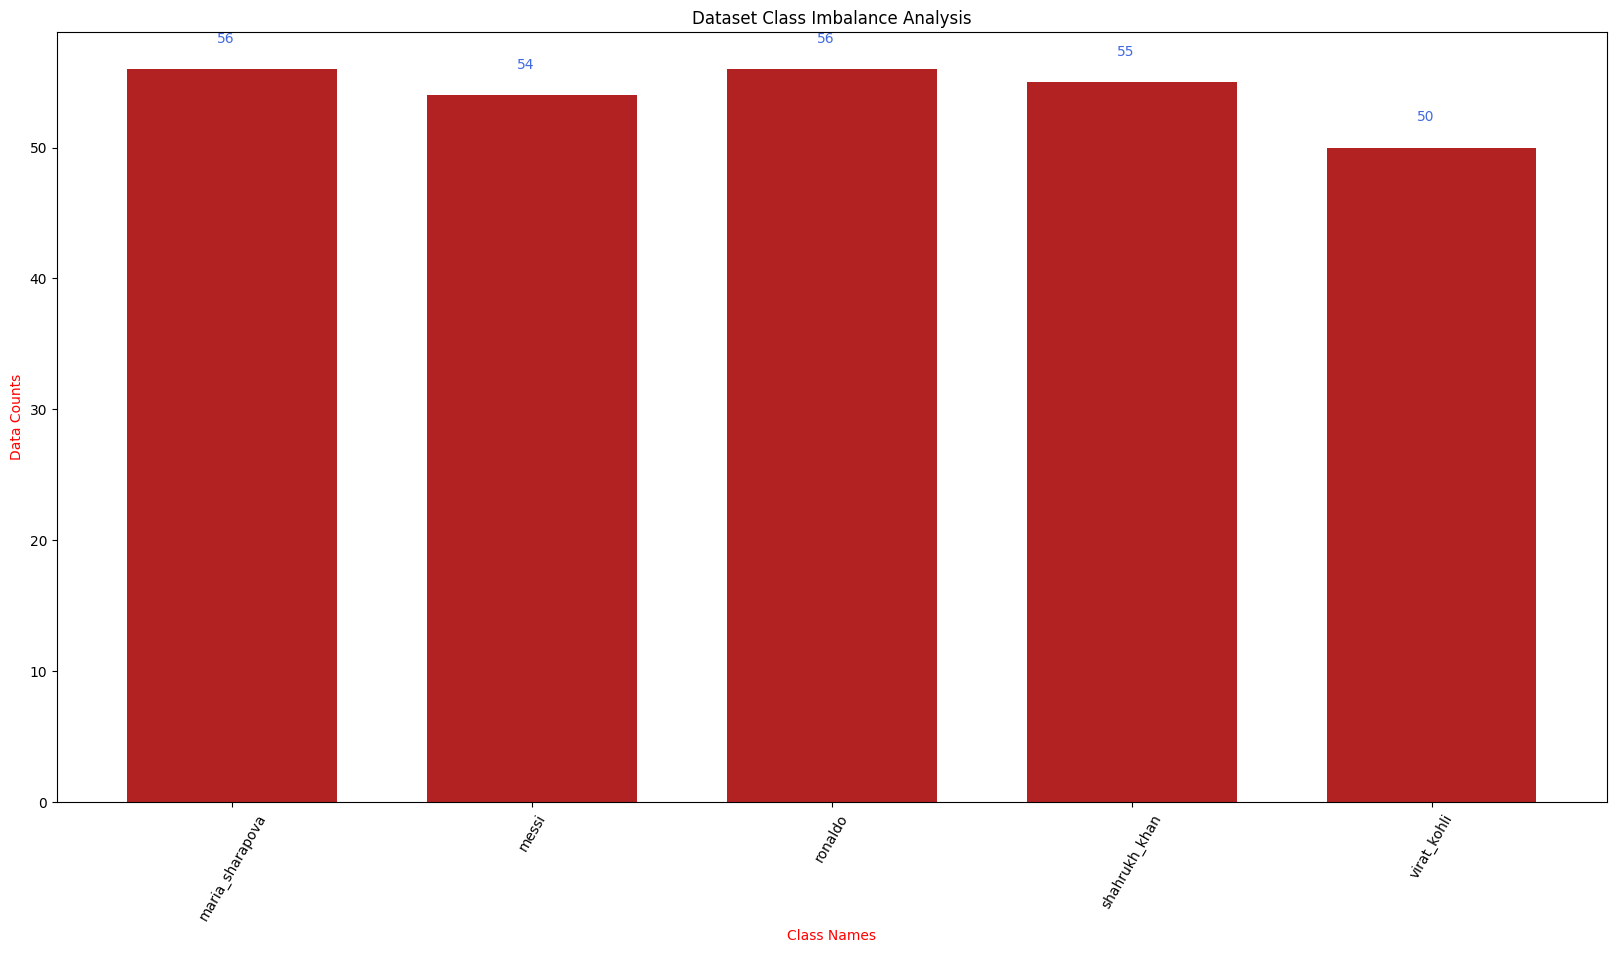

In [17]:
def data_analysis(root, transformations):
    
    ds = CustomData(root = root, transformations = transformations)
    cls_counts, width, text_width = ds.cls_counts,  0.7, 0.05
    text_height = 2
    cls_names = list(cls_counts.keys()); counts = list(cls_counts.values())
    
    fig, ax = plt.subplots(figsize = (20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color = "firebrick")
    ax.set_xlabel("Class Names", color = "red")
    ax.set_xticklabels(cls_names, rotation = 60)
    ax.set(xticks = indices, xticklabels = cls_names)
    ax.set_ylabel("Data Counts", color = "red")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")
    
data_analysis(root = root, transformations = tfs)

In [18]:
import timm ,torchmetrics
from tqdm import tqdm

m = timm.create_model('rexnet_150',pretrained=True,num_classes=len(classes))

In [19]:
def train_setup(m):
    return m.to("cuda").eval(), 10, "cuda", torch.nn.CrossEntropyLoss(), \
    torch.optim.Adam(params = m.parameters(), lr = 3e-4)
def to_device(batch, device):
    return batch[0].to(device), batch[1].to(device)
def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1):
    preds = model(ims)
    loss = loss_fn(preds, gts)
    return loss, epoch_loss + (loss.item()), \
        epoch_acc + (torch.argmax(preds, dim = 1) == gts).\
        sum().item(), epoch_f1 + f1_score(preds, gts)

In [20]:
torch.cuda.memory_stats()

OrderedDict()

In [21]:
torch.cuda.empty_cache()

In [22]:
torch.cuda.memory_stats()

OrderedDict()

In [23]:
m, epochs, device, loss_fn, optimizer = train_setup(m)

f1_score = torchmetrics.F1Score(task = "multiclass", num_classes = len(classes)).to(device)
save_prefix, save_dir = "food", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5
tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s = [], [], [], [], [], []

best_loss = float(torch.inf)
    
for epoch in range(epochs):

    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):

        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc, epoch_f1 = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc  / len(tr_dl.dataset)
    tr_f1_to_track   = epoch_f1   / len(tr_dl)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track); tr_f1s.append(tr_f1_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")
    print(f"{epoch + 1}-epoch train f1-score      -> {tr_f1_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_epoch_f1 = 0, 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = to_device(batch, device)
            loss, val_epoch_loss, val_epoch_acc, val_epoch_f1 = get_metrics(m, ims, gts, loss_fn, val_epoch_loss, val_epoch_acc, val_epoch_f1)

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track  = val_epoch_acc  / len(val_dl.dataset)
        val_f1_to_track   = val_epoch_f1   / len(val_dl)
        val_losses.append(val_loss_to_track); val_accs.append(val_acc_to_track); val_f1s.append(val_f1_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation f1-score -> {val_f1_to_track:.3f}")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")
            
        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break

Start training...


0it [00:01, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 22.00 MiB. GPU 0 has a total capacity of 3.81 GiB of which 38.31 MiB is free. Including non-PyTorch memory, this process has 3.43 GiB memory in use. Of the allocated memory 3.29 GiB is allocated by PyTorch, and 70.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)